In [45]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.metrics import precision_recall_curve, auc, brier_score_loss, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path

In [46]:
# Make sure we can open the db file
try:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
    os.chdir(root)
except Exception:
    while not (Path.cwd() / "data").exists() and Path.cwd() != Path.home():
        os.chdir("..")

print("Working directory:", Path.cwd())

Working directory: /Users/ecasto/cs230-project


In [47]:
conn = sqlite3.connect("data/routes_scores.db")
df = pd.read_sql("SELECT * FROM routes;", conn)

In [48]:
df["county_count"] = df["counties"].str.count(",").fillna(0).astype(int) + 1

numeric_features = ["county_count"]
text_feature = "counties"
target = "impacting_delivery"

df[text_feature] = df[text_feature].fillna("")

print("Label distribution:\n", df[target].value_counts(normalize=True))

Label distribution:
 impacting_delivery
0    0.76505
1    0.23495
Name: proportion, dtype: float64


In [49]:
# ---------------------------------------------------------------
# Split data (70/15/15)
# ---------------------------------------------------------------
train, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df[target])
train, val  = train_test_split(train, test_size=0.1765, random_state=42, stratify=train[target])

X_train, y_train = train[[text_feature] + numeric_features], train[target]
X_val,   y_val   = val[[text_feature] + numeric_features],   val[target]
X_test,  y_test  = test[[text_feature] + numeric_features],  test[target]

In [50]:
# ---------------------------------------------------------------
# Preprocessing
# ---------------------------------------------------------------

to_1d = FunctionTransformer(lambda x: x.squeeze(), validate=False)

county_bow = Pipeline(steps=[
    ("to_1d", to_1d),
    ("vec", CountVectorizer(
        tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
        lowercase=False,
        min_df=5
    ))
])

numeric_pipe = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ("county_bow", county_bow, [text_feature]),
    ("num", numeric_pipe, numeric_features),
])

In [51]:
# ------------------------------
# Random Forest model
# ------------------------------
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )),
])

rf.fit(X_train, y_train)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('county_bow', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
val_probs = rf.predict_proba(X_val)[:, 1]
prec_v, rec_v, thr_v = precision_recall_curve(y_val, val_probs)

# Choose threshold that maximizes F1 on val
f1_v = (2 * prec_v * rec_v) / (prec_v + rec_v + 1e-12)
best_idx = np.nanargmax(f1_v)
best_thr = thr_v[best_idx] if best_idx < len(thr_v) else 0.5
print(f"Chosen threshold from val (F1-optimal): {best_thr:.3f}")

Chosen threshold from val (F1-optimal): 0.404


In [53]:
# ------------------------------
# Evaluate performance
# ------------------------------
probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

auc_pr = auc(recall, precision)
brier  = brier_score_loss(y_test, probs)

print("AUPRC:", auc_pr)
print("Brier Score:", brier)
print("\nClassification Report:\n")
print(classification_report(y_test, rf.predict(X_test)))

os.makedirs("results", exist_ok=True)
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (RF, AUC={auc_pr:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.savefig("results/pr_curve_random_forest.png", dpi=150)
plt.close()

AUPRC: 0.8970652103196126
Brier Score: 0.07120121866666666

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2295
           1       0.84      0.76      0.80       705

    accuracy                           0.91      3000
   macro avg       0.88      0.86      0.87      3000
weighted avg       0.91      0.91      0.91      3000



In [54]:
# ------------------------------
# Feature importance
# ------------------------------
pre = rf.named_steps["preprocess"]
vec = pre.named_transformers_["county_bow"].named_steps["vec"]

bow_names = vec.get_feature_names_out()
num_names = np.array(["county_count"])

feat_names = np.concatenate([
    [f"county:{t}" for t in bow_names],
    [f"num:{n}" for n in num_names],
])

importances = rf.named_steps["model"].feature_importances_

imp_df = pd.DataFrame(
    {"feature": feat_names, "importance": importances}
).sort_values("importance", ascending=False)

imp_df.to_csv("results/rf_feature_importances.csv", index=False)
imp_df.head(15)


,feature,importance
178,county:SAN BERNARDINO,0.054176
83,county:KERN,0.034005
182,county:SAN DIEGO,0.033845
170,county:RIVERSIDE,0.028420
312,num:county_count,0.028366
78,county:INYO,0.028008
60,county:FRESNO,0.026817
272,county:TULARE,0.026515
233,county:SONOMA,0.022912
94,county:LOS ANGELES,0.021630


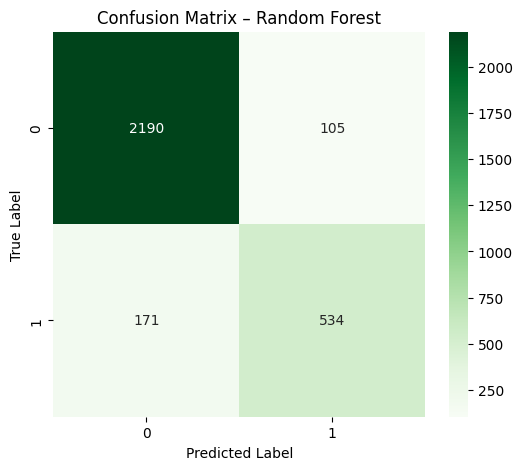

In [55]:
#Confusion matrix for random forest
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf_preds = (rf.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
cm_rf = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_random_forest.png", dpi=150)
plt.show()

Identify the routes the model got most wrong

In [56]:
results_df = X_test.copy()
results_df["y_true"] = y_test.values
results_df["y_prob"] = probs
results_df["y_pred"] = (results_df["y_prob"] >= 0.5).astype(int)

# FALSE NEGATIVES
worst_fn = results_df[(results_df.y_true == 1) & (results_df.y_pred == 0)] \
    .sort_values("y_prob") \
    .head(10)

# FALSE POSITIVES
worst_fp = results_df[(results_df.y_true == 0) & (results_df.y_pred == 1)] \
    .sort_values("y_prob", ascending=False) \
    .head(10)

worst_fn.to_csv("results/rf_worst_fn.csv", index=False)
worst_fp.to_csv("results/rf_worst_fp.csv", index=False)

worst_fn, worst_fp

(                                                counties  county_count  \
 681    SANTA SUSANA MOUNTAINS,EASTERN SANTA CLARA HIL...             3   
 13068  STANISLAUS,JOSHUA TREE NP WEST,SURPRISE VALLEY...             6   
 10258  NORTH COAST INTERIOR,SANTA BARBARA COUNTY SOUT...             7   
 2039   AMADOR,Kern County Mountains,EST SAN FERNANDO ...             5   
 2937   LOS ANGELES COUNTY BEACHES,Southwest San Joaqu...             4   
 1458   NORTHWESTERN LOS ANGELES COUNTY MOUNTAINS INCL...             6   
 6972   SUTTER,San Diego County Deserts,LOS ANGELES CO...             7   
 7724   JOSHUA TREE NP WEST,EAST BAY HILLS,SAN LUIS OB...             5   
 2742   SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...             5   
 2232   CENTRAL VENTURA COUNTY VALLEYS,SAN BERNARDINO ...             4   
 
        y_true  y_prob  y_pred  
 681         1   0.012       0  
 13068       1   0.050       0  
 10258       1   0.052       0  
 2039        1   0.062       0  
 2937   

County-level misclassification

In [57]:
def explode_counties(df):
    df_copy = df.copy()
    df_copy["county_list"] = df_copy["counties"].str.split(",")
    return df_copy.explode("county_list")

expanded = explode_counties(results_df)

# Compute misclassification rates
expanded["is_wrong"] = (expanded.y_true != expanded.y_pred).astype(int)

county_error = expanded.groupby("county_list")["is_wrong"].mean().sort_values(ascending=False)

county_error.head(20)

county_list
MOJAVE DESERT SLOPE(S)                                             0.258065
ORANGE                                                             0.250000
ALAMEDA                                                            0.237288
INYO                                                               0.227273
SANTA BARBARA                                                      0.227273
TULARE                                                             0.218750
IMPERIAL                                                           0.213115
MARIPOSA                                                           0.209302
EST SANTA MONICA MOUNTAINS                                         0.207547
Modoc County                                                       0.200000
HUMBOLDT                                                           0.197368
LOS ANGELES                                                        0.196970
SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - THE INLAND EMPIRE    0.193548


In [58]:
pd.DataFrame([{"AUPRC": auc_pr, "brier_score": brier}]).to_csv(
    "results/random_forest_metrics.csv", index=False
)

print("✅ Random Forest run complete. Artifacts written to results/")

✅ Random Forest run complete. Artifacts written to results/


In [60]:
# ---- Feature Importance for Random Forest ----

rf_model = rf.named_steps["model"]
pre = rf.named_steps["preprocess"]

# 1. Get feature names from CountVectorizer inside the pipeline
vec = pre.named_transformers_["county_bow"].named_steps["vec"]
bow_features = vec.get_feature_names_out()

# 2. Numeric features:
numeric_features = pre.named_transformers_["num"].get_feature_names_out()

# 3. Concatenate both
feature_names = np.concatenate([bow_features, numeric_features])

print("Total feature count:", len(feature_names))

importances = rf_model.feature_importances_
idx = np.argsort(importances)[::-1]

top_k = 20  # shows the 20 most important features
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[idx][:top_k][::-1],
         importances[idx][:top_k][::-1])
plt.title("Random Forest Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("results/rf_feature_importance.png")
plt.close()

Total feature count: 313


In [ ]:
#Save results for error analysis
np.save("results/rf_probs.npy", probs)
np.save("results/rf_y_test.npy", y_test.values)